In [1]:
import time

import matplotlib.pyplot as plt
from pytorch_lightning.metrics.functional import accuracy, precision_recall, f1
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from model import GarbageModel
from util import make_ensemble, time_to_string

In [2]:
model_paths = [
    # "logs/default/version_18/last.ckpt",
    # "logs/default/version_19/last.ckpt",
    # "logs/default/version_20/last.ckpt",
    # "logs/default/version_21/last.ckpt",
    # "logs/default/version_22/last.ckpt",
    "logs/default/version_23/last.ckpt",
    "logs/default/version_24/last.ckpt",
]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device : {}".format(device))
model = make_ensemble(model_paths, GarbageModel, device)

Device : cuda:0
 * Loading ensemble ...
Adding logs/default/version_23/last.ckpt
Adding logs/default/version_24/last.ckpt
Categories : [0, 1, 2, 3, 4]
Input Size : 224
 * Ensemble loaded.


In [3]:
# root = "data/test448"
root = r"C:\Users\LUKE_SARGEN\projects\classifier\data\test512"
batch_size = 128
use_crops = True
input_size = 160  # model.input_size, 128, 144, 160, 192, 224, 256, 288, 320, 384, 448

if use_crops:
    valid_transform = T.Compose([
        T.Resize(int(1.1*input_size)),
        T.FiveCrop(input_size),
        # T.TenCrop(input_size),
        T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])),
    ])
else:
    valid_transform = T.Compose([
        T.Resize(input_size),
        T.CenterCrop(input_size),
        T.ToTensor(),
    ])

valid_ds = ImageFolder(root=root, transform=valid_transform)
num_classes = len(valid_ds.classes)
val_loader = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, num_workers=0)
print("{} Test Samples.".format(len(valid_ds)))

3000 Test Samples.


In [4]:
yhats = []  # All model predictions
ensemble = []  # Mean prediction
targets = []  # Targets
t0 = time.time()
for i, (data, target) in enumerate(val_loader):
    data = data.to(device)

    if use_crops:
        bs, ncrops, c, h, w = data.size()
        data = data.view(-1, c, h, w)
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1).view(bs, ncrops, -1).mean(1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])
    else:
        with torch.no_grad():
            ymodels = [torch.softmax(m(data.clone()), dim=1) for m in model.models]
        avg_pred = torch.mean(torch.stack(ymodels), dim=0)
        yhat = torch.stack([torch.argmax(y, dim=1) for y in ymodels])

    yhats.append(yhat)
    ensemble.append(avg_pred)
    targets.append(target)
    if i%max(1, int(len(valid_ds)/(batch_size*10)))==0:
        c = len(targets)*batch_size
        duration = time.time()-t0
        remaining = duration/c * (len(valid_ds)-c)
        print("image {}/{}. {:.1f} images/second. elapsed={}. remaining={}.".format(c, len(valid_ds), c/duration, time_to_string(duration), time_to_string(remaining)))

preds = torch.cat(yhats, dim=1).cpu()
pred = torch.argmax(torch.cat(ensemble), dim=1).cpu()
target = torch.cat(targets).cpu()

c = len(target)
duration = time.time()-t0
remaining = duration/c * (len(valid_ds)-c)
print("image {}/{}. {:.1f} images/second. elapsed={}.".format(c, len(valid_ds), c/duration, time_to_string(duration)))

print("preds.shape :", preds.shape)
print("pred.shape :", pred.shape)
print("target.shape :", target.shape)


image 128/3000. 73.0 images/second. elapsed=1.75 seconds. remaining=39.36 seconds.
image 384/3000. 95.0 images/second. elapsed=4.04 seconds. remaining=27.54 seconds.
image 640/3000. 103.6 images/second. elapsed=6.18 seconds. remaining=22.79 seconds.
image 896/3000. 107.0 images/second. elapsed=8.37 seconds. remaining=19.67 seconds.
image 1152/3000. 108.6 images/second. elapsed=10.61 seconds. remaining=17.02 seconds.
image 1408/3000. 109.7 images/second. elapsed=12.84 seconds. remaining=14.51 seconds.
image 1664/3000. 109.3 images/second. elapsed=15.22 seconds. remaining=12.22 seconds.
image 1920/3000. 109.7 images/second. elapsed=17.50 seconds. remaining=9.84 seconds.
image 2176/3000. 110.4 images/second. elapsed=19.72 seconds. remaining=7.47 seconds.
image 2432/3000. 110.8 images/second. elapsed=21.94 seconds. remaining=5.12 seconds.
image 2688/3000. 110.9 images/second. elapsed=24.23 seconds. remaining=2.81 seconds.
image 2944/3000. 111.5 images/second. elapsed=26.41 seconds. remaini

In [5]:
def stats(pred, target):
    acc = accuracy(pred, target)
    avg_precision, avg_recall = precision_recall(pred, target, num_classes=num_classes, average="macro", mdmc_average="global")
    weighted_f1 = f1(pred, target, num_classes=num_classes, threshold=0.5, average="weighted")
    return 100*acc, 100*avg_precision, 100*avg_recall, 100*weighted_f1

archs = [m.hparams.model for m in model.models]
headers = ["Model", "Arch", "Accuracy", "Precision", "Recall", "F1 Score"]
hw = max(len(n) for n in headers)
aw = max(len(n) for n in archs)
width = max(len(n) for n in headers)
head_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>{hw}s}'*(len(headers)-2) + '\n'
row_fmt = '{:>{hw}s}' + ' {:>{aw}s}' + ' {:>9.2f}'*(len(headers)-2) + '\n'
stat_str = head_fmt.format(*headers, hw=hw, aw=aw)
for i in range(len(model.models)):
    row = stats(preds[i, :], target)
    stat_str += row_fmt.format(str(i), str(archs[i]),*row, hw=hw, aw=aw)
row = stats(pred, target)
stat_str += row_fmt.format("Ensemble", "", *row, hw=hw, aw=aw)
print(stat_str)

    Model               Arch  Accuracy Precision    Recall  F1 Score
        0 shufflenet_v2_x1_0     56.47     57.12     56.47     56.03
        1 shufflenet_v2_x1_0     56.50     56.93     56.50     56.39
 Ensemble                        57.03     57.43     57.03     56.74



C:\Users\LUKE_SARGEN\anaconda3\envs\pytorch19cu11\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
C:\Users\LUKE_SARGEN\anaconda3\envs\pytorch19cu11\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `precision_recall` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.precision_recall.precision_recall`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
C:\Users\LUKE_SARGEN\anaconda3\envs\pytorch19cu11\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `f1` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.f_beta.f1`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [8]:
print( classification_report(target, pred, target_names=model.classes, digits=4) )

              precision    recall  f1-score   support

           0     0.4920    0.4083    0.4463       600
           1     0.6380    0.5933    0.6149       600
           2     0.6432    0.5950    0.6182       600
           3     0.5160    0.7250    0.6029       600
           4     0.5824    0.5300    0.5550       600

    accuracy                         0.5703      3000
   macro avg     0.5743    0.5703    0.5674      3000
weighted avg     0.5743    0.5703    0.5674      3000



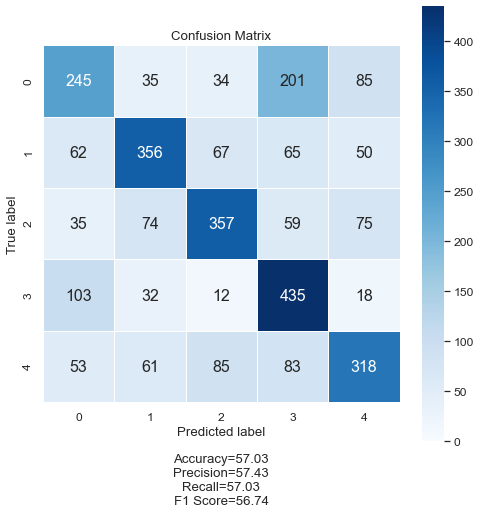

In [9]:
cm = confusion_matrix(target, pred)
plt.figure(figsize=(8, 8))
sn.set(font_scale=1.1)  # Label size
sn.heatmap(cm, annot=True, fmt="d",
cmap='Blues',
# cbar=False,
vmin=0,
xticklabels=model.classes,  yticklabels=model.classes, annot_kws={"size": 16}, square=True, linewidths=0.5)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label\n\nAccuracy={:.2f}\nPrecision={:.2f}\nRecall={:.2f}\nF1 Score={:.2f}'.format(*row))
plt.savefig('data/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()